In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
# import Ngl
# import Nio 
# import metpy.calc as mpc
# from metpy.units import units


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
## Function from Brian Medeiros to convert times to middle of period 
#  rather than the end of the averaging period. 

def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data *without* T relaxation 

In [4]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-08-09-36585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.cam.h0.2015-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-08-09-36585.nc'])

htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_3monthsFree.clm2.h0.2015-08-09-36585.nc'])

for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2015 = HTGcamDS 
        HMGcamDS_all2015 = HMGcamDS
        HTGclmDS_all2015 = HTGclmDS
        HMGclmDS_all2015 = HMGclmDS 
    else: 
        HTGcamDS_all2015 = xr.concat([HTGcamDS_all2015, HTGcamDS], dim='time')
        HMGcamDS_all2015 = xr.concat([HMGcamDS_all2015, HMGcamDS], dim='time')
        HTGclmDS_all2015 = xr.concat([HTGclmDS_all2015,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2015 = xr.concat([HMGclmDS_all2015,HMGclmDS], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [5]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2016
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-08-09-36585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.cam.h0.2016-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-08-09-36585.nc'])

htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_2016jja.clm2.h0.2016-08-09-36585.nc'])

for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2016 = HTGcamDS 
        HMGcamDS_all2016 = HMGcamDS
        HTGclmDS_all2016 = HTGclmDS
        HMGclmDS_all2016 = HMGclmDS 
    else: 
        HTGcamDS_all2016 = xr.concat([HTGcamDS_all2016, HTGcamDS], dim='time')
        HMGcamDS_all2016 = xr.concat([HMGcamDS_all2016, HMGcamDS], dim='time')
        HTGclmDS_all2016 = xr.concat([HTGclmDS_all2016,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2016 = xr.concat([HMGclmDS_all2016,HMGclmDS], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


## Read in data *with* T relaxation, on two timescales

**Shorter time scale relaxation**

In [6]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2015jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2015jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2015-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2015-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2015-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2015-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2015-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2015-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2015-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2015-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2015-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2015-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2015-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2015-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2015-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2015-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2015-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2015-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2015-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2015-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2015_shortTau = HTGcamDS 
        HMGcamDS_all2015_shortTau = HMGcamDS
        HTGclmDS_all2015_shortTau = HTGclmDS
        HMGclmDS_all2015_shortTau = HMGclmDS 
        HTGclmDSpatch_all2015_shortTau = HTGclmDS_patch
        HMGclmDSpatch_all2015_shortTau = HMGclmDS_patch
    else: 
        HTGcamDS_all2015_shortTau = xr.concat([HTGcamDS_all2015_shortTau, HTGcamDS], dim='time')
        HMGcamDS_all2015_shortTau = xr.concat([HMGcamDS_all2015_shortTau, HMGcamDS], dim='time')
        HTGclmDS_all2015_shortTau = xr.concat([HTGclmDS_all2015_shortTau,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2015_shortTau = xr.concat([HMGclmDS_all2015_shortTau,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2015_shortTau = xr.concat([HTGclmDSpatch_all2015_shortTau,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2015_shortTau = xr.concat([HMGclmDSpatch_all2015_shortTau,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [7]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2016
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2016jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_2016jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2016-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2016-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2016-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2016-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2016-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2016-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2016-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2016-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2016-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2016-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2016-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2016-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2016-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2016-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2016-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2016-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2016-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2016-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
    
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2016_shortTau = HTGcamDS 
        HMGcamDS_all2016_shortTau = HMGcamDS
        HTGclmDS_all2016_shortTau = HTGclmDS
        HMGclmDS_all2016_shortTau = HMGclmDS 
        HTGclmDSpatch_all2016_shortTau = HTGclmDS_patch
        HMGclmDSpatch_all2016_shortTau = HMGclmDS_patch
    else: 
        HTGcamDS_all2016_shortTau = xr.concat([HTGcamDS_all2016_shortTau, HTGcamDS], dim='time')
        HMGcamDS_all2016_shortTau = xr.concat([HMGcamDS_all2016_shortTau, HMGcamDS], dim='time')
        HTGclmDS_all2016_shortTau = xr.concat([HTGclmDS_all2016_shortTau,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2016_shortTau = xr.concat([HMGclmDS_all2016_shortTau,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2016_shortTau = xr.concat([HTGclmDSpatch_all2016_shortTau,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2016_shortTau = xr.concat([HMGclmDSpatch_all2016_shortTau,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


**Longer time scale relaxation**

In [8]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptionsLongerTau_2015jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptionsLongerTau_2015jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2015-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2015-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2015-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2015-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2015-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2015-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2015-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2015-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2015-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2015-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2015-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2015-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2015-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2015-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2015-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2015-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2015-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2015-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2015_longTau = HTGcamDS 
        HMGcamDS_all2015_longTau = HMGcamDS
        HTGclmDS_all2015_longTau = HTGclmDS
        HMGclmDS_all2015_longTau = HMGclmDS 
        HTGclmDSpatch_all2015_longTau = HTGclmDS_patch
        HMGclmDSpatch_all2015_longTau = HMGclmDS_patch
    else: 
        HTGcamDS_all2015_longTau = xr.concat([HTGcamDS_all2015_longTau, HTGcamDS], dim='time')
        HMGcamDS_all2015_longTau = xr.concat([HMGcamDS_all2015_longTau, HMGcamDS], dim='time')
        HTGclmDS_all2015_longTau = xr.concat([HTGclmDS_all2015_longTau,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2015_longTau = xr.concat([HMGclmDS_all2015_longTau,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2015_longTau = xr.concat([HTGclmDSpatch_all2015_longTau,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2015_longTau = xr.concat([HMGclmDSpatch_all2015_longTau,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [9]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptionsLongerTau_2016jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptionsLongerTau_2016jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2016-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2016-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2016-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2016-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2016-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2016-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2016-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2016-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2016-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2016-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2016-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2016-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2016-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2016-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2016-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2016-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2016-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2016-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2016_longTau = HTGcamDS 
        HMGcamDS_all2016_longTau = HMGcamDS
        HTGclmDS_all2016_longTau = HTGclmDS
        HMGclmDS_all2016_longTau = HMGclmDS 
        HTGclmDSpatch_all2016_longTau = HTGclmDS_patch
        HMGclmDSpatch_all2016_longTau = HMGclmDS_patch
    else: 
        HTGcamDS_all2016_longTau = xr.concat([HTGcamDS_all2016_longTau, HTGcamDS], dim='time')
        HMGcamDS_all2016_longTau = xr.concat([HMGcamDS_all2016_longTau, HMGcamDS], dim='time')
        HTGclmDS_all2016_longTau = xr.concat([HTGclmDS_all2016_longTau,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2016_longTau = xr.concat([HMGclmDS_all2016_longTau,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2016_longTau = xr.concat([HTGclmDSpatch_all2016_longTau,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2016_longTau = xr.concat([HMGclmDSpatch_all2016_longTau,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


## Get usable arrays 

In [11]:

## Discard spin up days 
iTimeStart   = np.where(HTGcamDS_all2015.time.values >= (HTGcamDS_all2015.time.values[0] + np.timedelta64(2,'D')))[0]
timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2015.time.values))

HTGcamDS_all2015 = HTGcamDS_all2015.isel(time=timeArr)
HTGclmDS_all2015 = HTGclmDS_all2015.isel(time=timeArr)
HMGcamDS_all2015 = HMGcamDS_all2015.isel(time=timeArr)
HMGclmDS_all2015 = HMGclmDS_all2015.isel(time=timeArr)

iTimeStart   = np.where(HTGcamDS_all2016.time.values >= (HTGcamDS_all2016.time.values[0] + np.timedelta64(2,'D')))[0]
timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2016.time.values))

HTGcamDS_all2016 = HTGcamDS_all2016.isel(time=timeArr)
HTGclmDS_all2016 = HTGclmDS_all2016.isel(time=timeArr)
HMGcamDS_all2016 = HMGcamDS_all2016.isel(time=timeArr)
HMGclmDS_all2016 = HMGclmDS_all2016.isel(time=timeArr)


## Concat into one giant DS
HTGcamDS_all = xr.concat([HTGcamDS_all2015, HTGcamDS_all2016], dim='time')
HMGcamDS_all = xr.concat([HMGcamDS_all2015, HMGcamDS_all2016], dim='time')
HTGclmDS_all = xr.concat([HTGclmDS_all2015, HTGclmDS_all2016], dim='time')
HMGclmDS_all = xr.concat([HMGclmDS_all2015, HMGclmDS_all2016], dim='time')



In [12]:

## Discard spin up days 
iTimeStart   = np.where(HTGcamDS_all2015_shortTau.time.values >= (HTGcamDS_all2015_shortTau.time.values[0] + np.timedelta64(2,'D')))[0]
timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2015_shortTau.time.values))

HTGcamDS_all2015_shortTau = HTGcamDS_all2015_shortTau.isel(time=timeArr)
HTGclmDS_all2015_shortTau = HTGclmDS_all2015_shortTau.isel(time=timeArr)
HMGcamDS_all2015_shortTau = HMGcamDS_all2015_shortTau.isel(time=timeArr)
HMGclmDS_all2015_shortTau = HMGclmDS_all2015_shortTau.isel(time=timeArr)

iTimeStart   = np.where(HTGcamDS_all2016_shortTau.time.values >= (HTGcamDS_all2016_shortTau.time.values[0] + np.timedelta64(2,'D')))[0]
timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2016_shortTau.time.values))

HTGcamDS_all2016_shortTau = HTGcamDS_all2016_shortTau.isel(time=timeArr)
HTGclmDS_all2016_shortTau = HTGclmDS_all2016_shortTau.isel(time=timeArr)
HMGcamDS_all2016_shortTau = HMGcamDS_all2016_shortTau.isel(time=timeArr)
HMGclmDS_all2016_shortTau = HMGclmDS_all2016_shortTau.isel(time=timeArr)


## Concat into one giant DS
HTGcamDS_all_shortTau = xr.concat([HTGcamDS_all2015_shortTau, HTGcamDS_all2016_shortTau], dim='time')
HMGcamDS_all_shortTau = xr.concat([HMGcamDS_all2015_shortTau, HMGcamDS_all2016_shortTau], dim='time')
HTGclmDS_all_shortTau = xr.concat([HTGclmDS_all2015_shortTau, HTGclmDS_all2016_shortTau], dim='time')
HMGclmDS_all_shortTau = xr.concat([HMGclmDS_all2015_shortTau, HMGclmDS_all2016_shortTau], dim='time')


In [13]:

## Discard spin up days 
iTimeStart   = np.where(HTGcamDS_all2015_longTau.time.values >= (HTGcamDS_all2015_longTau.time.values[0] + np.timedelta64(2,'D')))[0]
timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2015_longTau.time.values))

HTGcamDS_all2015_longTau = HTGcamDS_all2015_longTau.isel(time=timeArr)
HTGclmDS_all2015_longTau = HTGclmDS_all2015_longTau.isel(time=timeArr)
HMGcamDS_all2015_longTau = HMGcamDS_all2015_longTau.isel(time=timeArr)
HMGclmDS_all2015_longTau = HMGclmDS_all2015_longTau.isel(time=timeArr)

iTimeStart   = np.where(HTGcamDS_all2016_longTau.time.values >= (HTGcamDS_all2016_longTau.time.values[0] + np.timedelta64(2,'D')))[0]
timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2016_longTau.time.values))

HTGcamDS_all2016_longTau = HTGcamDS_all2016_longTau.isel(time=timeArr)
HTGclmDS_all2016_longTau = HTGclmDS_all2016_longTau.isel(time=timeArr)
HMGcamDS_all2016_longTau = HMGcamDS_all2016_longTau.isel(time=timeArr)
HMGclmDS_all2016_longTau = HMGclmDS_all2016_longTau.isel(time=timeArr)


## Concat into one giant DS
HTGcamDS_all_longTau = xr.concat([HTGcamDS_all2015_longTau, HTGcamDS_all2016_longTau], dim='time')
HMGcamDS_all_longTau = xr.concat([HMGcamDS_all2015_longTau, HMGcamDS_all2016_longTau], dim='time')
HTGclmDS_all_longTau = xr.concat([HTGclmDS_all2015_longTau, HTGclmDS_all2016_longTau], dim='time')
HMGclmDS_all_longTau = xr.concat([HMGclmDS_all2015_longTau, HMGclmDS_all2016_longTau], dim='time')


## Plot things

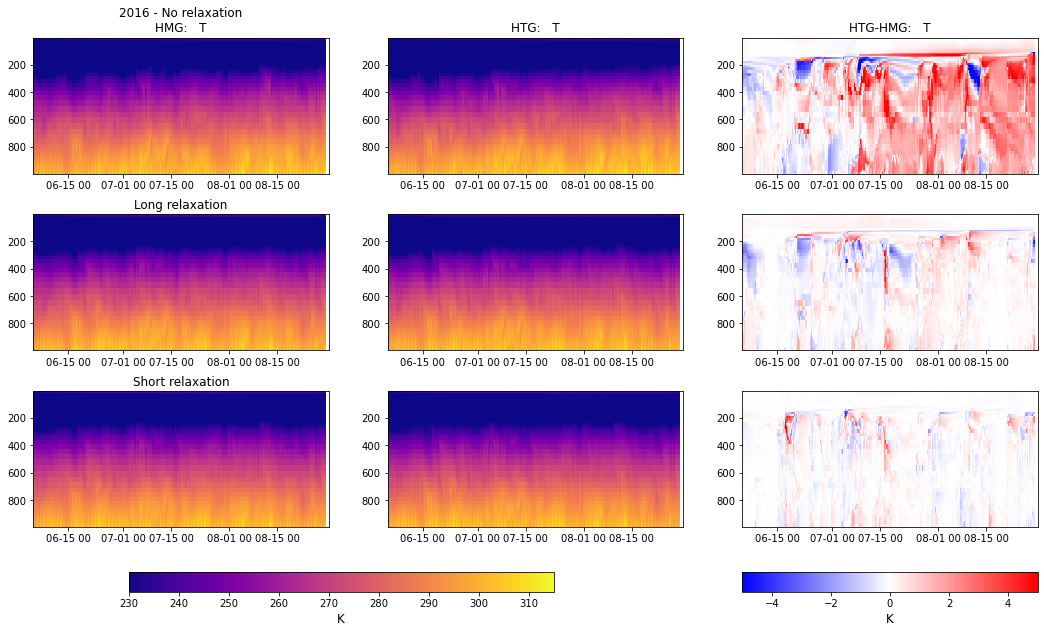

In [43]:
varSel = 'T'

startDay   = 4
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2016
endYear    = 2016

## Now set up figure itself 
fig,axs = plt.subplots(3,3, figsize=(18,9))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.3)


# Plot no relaxation option
# - - - - - - - - - - - - - - 
contour_plot   = axs[0].pcolormesh(HMGcamDS_all.time, HMGcamDS_all.lev.values, 
                                   np.transpose(np.squeeze(HMGcamDS_all[varSel].values)),
                                   vmin=230, vmax=315,
                                   cmap = 'plasma')

contour_plot   = axs[1].pcolormesh(HTGcamDS_all.time, HTGcamDS_all.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all[varSel].values)),
                                   vmin=230, vmax=315,
                                   cmap = 'plasma')

contour_plot   = axs[2].pcolormesh(HTGcamDS_all.time, HTGcamDS_all.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all[varSel].values - HMGcamDS_all[varSel].values)),
                                   vmin=-5, vmax=5,
                                   cmap = 'bwr')


axs[0].set_title(str(startYear)+' - No relaxation\nHMG:   '+varSel)
axs[1].set_title('\nHTG:   '+varSel)
axs[2].set_title('\nHTG-HMG:   '+varSel)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[1].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[2].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])

# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 


# Plot long relaxation option 
# - - - - - - - - - - - - - - 
contour_plot   = axs[3].pcolormesh(HMGcamDS_all_longTau.time, HMGcamDS_all_longTau.lev.values, 
                                   np.transpose(np.squeeze(HMGcamDS_all_longTau[varSel].values)),
                                   vmin=230, vmax=315,
                                   cmap = 'plasma')

contour_plot   = axs[4].pcolormesh(HTGcamDS_all_longTau.time, HTGcamDS_all_longTau.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all_longTau[varSel].values)),
                                   vmin=230, vmax=315,
                                   cmap = 'plasma')

contour_plot   = axs[5].pcolormesh(HTGcamDS_all_longTau.time, HTGcamDS_all_longTau.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all_longTau[varSel].values - HMGcamDS_all_longTau[varSel].values)),
                                   vmin=-5, vmax=5,
                                   cmap = 'bwr')


axs[3].set_title('Long relaxation')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[3].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[4].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[5].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])

# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[5].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 


# Plot short relaxation option
# - - - - - - - - - - - - - - 
contour_plot   = axs[6].pcolormesh(HMGcamDS_all_shortTau.time, HMGcamDS_all_shortTau.lev.values, 
                                   np.transpose(np.squeeze(HMGcamDS_all_shortTau[varSel].values)),
                                   vmin=230, vmax=315,
                                   cmap = 'plasma')

contour_plot   = axs[7].pcolormesh(HTGcamDS_all_shortTau.time, HTGcamDS_all_shortTau.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all_shortTau[varSel].values)),
                                   vmin=230, vmax=315,
                                   cmap = 'plasma')

# Add colorbar 
ax_position = axs[7].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varSel].units,fontsize=12)


contour_plot   = axs[8].pcolormesh(HTGcamDS_all_shortTau.time, HTGcamDS_all_shortTau.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all_shortTau[varSel].values - HMGcamDS_all_shortTau[varSel].values)),
                                   vmin=-5, vmax=5,
                                   cmap = 'bwr')

# Add colorbar 
ax_position = axs[8].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varSel].units,fontsize=12)


axs[6].set_title('Short relaxation')


axs[6].invert_yaxis()
axs[7].invert_yaxis()
axs[8].invert_yaxis()

axs[6].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[7].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[8].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])

# Format the date into months & days
axs[6].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[7].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[8].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 



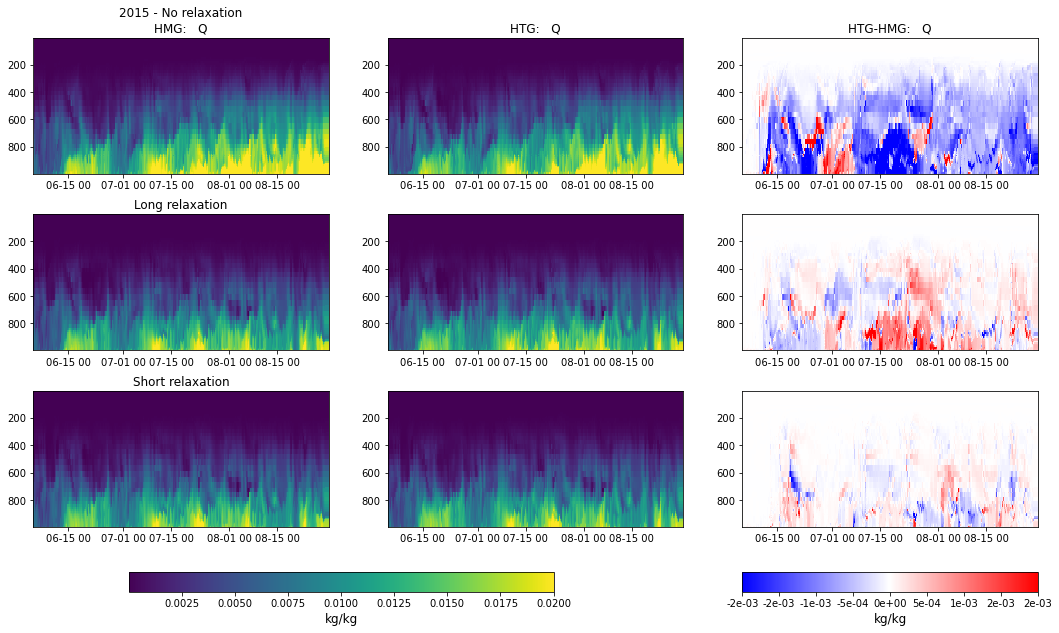

In [52]:
varSel = 'Q'

startDay   = 4
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

## Now set up figure itself 
fig,axs = plt.subplots(3,3, figsize=(18,9))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.3)


# Plot no relaxation option
# - - - - - - - - - - - - - - 
contour_plot   = axs[0].pcolormesh(HMGcamDS_all.time, HMGcamDS_all.lev.values, 
                                   np.transpose(np.squeeze(HMGcamDS_all[varSel].values)),
                                   vmin=0.1e-4, vmax=0.02,
                                   cmap = 'viridis')

contour_plot   = axs[1].pcolormesh(HTGcamDS_all.time, HTGcamDS_all.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all[varSel].values)),
                                   vmin=0.1e-4, vmax=0.02,
                                   cmap = 'viridis')

contour_plot   = axs[2].pcolormesh(HTGcamDS_all.time, HTGcamDS_all.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all[varSel].values - HMGcamDS_all[varSel].values)),
                                   vmin=-0.002, vmax=0.002,
                                   cmap = 'bwr')


axs[0].set_title(str(startYear)+' - No relaxation\nHMG:   '+varSel)
axs[1].set_title('\nHTG:   '+varSel)
axs[2].set_title('\nHTG-HMG:   '+varSel)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[1].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[2].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])

# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 


# Plot long relaxation option 
# - - - - - - - - - - - - - - 
contour_plot   = axs[3].pcolormesh(HMGcamDS_all_longTau.time, HMGcamDS_all_longTau.lev.values, 
                                   np.transpose(np.squeeze(HMGcamDS_all_longTau[varSel].values)),
                                   vmin=0.1e-4, vmax=0.02,
                                   cmap = 'viridis')

contour_plot   = axs[4].pcolormesh(HTGcamDS_all_longTau.time, HTGcamDS_all_longTau.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all_longTau[varSel].values)),
                                   vmin=0.1e-4, vmax=0.02,
                                   cmap = 'viridis')

contour_plot   = axs[5].pcolormesh(HTGcamDS_all_longTau.time, HTGcamDS_all_longTau.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all_longTau[varSel].values - HMGcamDS_all_longTau[varSel].values)),
                                   vmin=-0.002, vmax=0.002,
                                   cmap = 'bwr')


axs[3].set_title('Long relaxation')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[3].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[4].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[5].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])

# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[5].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 


# Plot short relaxation option
# - - - - - - - - - - - - - - 
contour_plot   = axs[6].pcolormesh(HMGcamDS_all_shortTau.time, HMGcamDS_all_shortTau.lev.values, 
                                   np.transpose(np.squeeze(HMGcamDS_all_shortTau[varSel].values)),
                                   vmin=0.1e-4, vmax=0.02,
                                   cmap = 'viridis')

contour_plot   = axs[7].pcolormesh(HTGcamDS_all_shortTau.time, HTGcamDS_all_shortTau.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all_shortTau[varSel].values)),
                                   vmin=0.1e-4, vmax=0.02,
                                   cmap = 'viridis')

# Add colorbar 
ax_position = axs[7].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all[varSel].units,fontsize=12)


contour_plot   = axs[8].pcolormesh(HTGcamDS_all_shortTau.time, HTGcamDS_all_shortTau.lev.values, 
                                   np.transpose(np.squeeze(HTGcamDS_all_shortTau[varSel].values - HMGcamDS_all_shortTau[varSel].values)),
                                   vmin=-0.002, vmax=0.002,
                                   cmap = 'bwr')

# Add colorbar 
ax_position = axs[8].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax, format='%.0e')
cbar.set_label(HTGcamDS_all[varSel].units,fontsize=12)


axs[6].set_title('Short relaxation')


axs[6].invert_yaxis()
axs[7].invert_yaxis()
axs[8].invert_yaxis()

axs[6].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[7].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[8].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])

# Format the date into months & days
axs[6].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[7].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 
axs[8].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 




## Look at more things

Convert things to local time for each array

In [53]:
## Convert to local times...
HMGcamDS_local       = HMGcamDS_all.copy(deep=True)
HTGcamDS_local       = HTGcamDS_all.copy(deep=True)
HMGclmDS_local       = HMGclmDS_all.copy(deep=True)
HTGclmDS_local       = HTGclmDS_all.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_all['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
HMGclmDS_local = HMGclmDS_local.assign_coords({"time": localTimes})
HTGclmDS_local = HTGclmDS_local.assign_coords({"time": localTimes})

In [54]:
## Convert to local times...
HMGcamDS_local_shortTau       = HMGcamDS_all_shortTau.copy(deep=True)
HTGcamDS_local_shortTau       = HTGcamDS_all_shortTau.copy(deep=True)
HMGclmDS_local_shortTau       = HMGclmDS_all_shortTau.copy(deep=True)
HTGclmDS_local_shortTau       = HTGclmDS_all_shortTau.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_all_shortTau['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HMGcamDS_local_shortTau = HMGcamDS_local_shortTau.assign_coords({"time": localTimes})
HTGcamDS_local_shortTau = HTGcamDS_local_shortTau.assign_coords({"time": localTimes})
HMGclmDS_local_shortTau = HMGclmDS_local_shortTau.assign_coords({"time": localTimes})
HTGclmDS_local_shortTau = HTGclmDS_local_shortTau.assign_coords({"time": localTimes})

In [55]:
## Convert to local times...
HMGcamDS_local_longTau       = HMGcamDS_all_longTau.copy(deep=True)
HTGcamDS_local_longTau       = HTGcamDS_all_longTau.copy(deep=True)
HMGclmDS_local_longTau       = HMGclmDS_all_longTau.copy(deep=True)
HTGclmDS_local_longTau       = HTGclmDS_all_longTau.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_all_longTau['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HMGcamDS_local_longTau = HMGcamDS_local_longTau.assign_coords({"time": localTimes})
HTGcamDS_local_longTau = HTGcamDS_local_longTau.assign_coords({"time": localTimes})
HMGclmDS_local_longTau = HMGclmDS_local_longTau.assign_coords({"time": localTimes})
HTGclmDS_local_longTau = HTGclmDS_local_longTau.assign_coords({"time": localTimes})

Get month_day_index in each array

In [57]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_local['time.year'].values,
                                                                HMGcamDS_local['time.month'].values, 
                                                                HMGcamDS_local['time.day'].values])
HMGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)

month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_local['time.year'].values,
                                                                HTGcamDS_local['time.month'].values, 
                                                                HTGcamDS_local['time.day'].values])
HTGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)


In [58]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_local_shortTau['time.year'].values,
                                                                HMGcamDS_local_shortTau['time.month'].values, 
                                                                HMGcamDS_local_shortTau['time.day'].values])
HMGcamDS_local_shortTau.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_local_shortTau.coords['year_month_day'] = ('time', month_day_idx)

month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_local_shortTau['time.year'].values,
                                                                HTGcamDS_local_shortTau['time.month'].values, 
                                                                HTGcamDS_local_shortTau['time.day'].values])
HTGcamDS_local_shortTau.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_local_shortTau.coords['year_month_day'] = ('time', month_day_idx)



In [59]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_local_longTau['time.year'].values,
                                                                HMGcamDS_local_longTau['time.month'].values, 
                                                                HMGcamDS_local_longTau['time.day'].values])
HMGcamDS_local_longTau.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_local_longTau.coords['year_month_day'] = ('time', month_day_idx)

month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_local_longTau['time.year'].values,
                                                                HTGcamDS_local_longTau['time.month'].values, 
                                                                HTGcamDS_local_longTau['time.day'].values])
HTGcamDS_local_longTau.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_local_longTau.coords['year_month_day'] = ('time', month_day_idx)



Now get daily summed rainfall

In [60]:
## Get daily means
HMGcamDS_localDailyMean = HMGcamDS_local.groupby('year_month_day').mean()
HTGcamDS_localDailyMean = HTGcamDS_local.groupby('year_month_day').mean()

HMGclmDS_localDailyMean = HMGclmDS_local.groupby('year_month_day').mean()
HTGclmDS_localDailyMean = HTGclmDS_local.groupby('year_month_day').mean()

## Add in daily total rain for fun... 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()

# Add to daily mean arrays above
HMGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySum['PRECT_mmPerDT'].values)
HTGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySum['PRECT_mmPerDT'].values)



In [61]:
## Get daily means
HMGcamDS_localDailyMean_shortTau = HMGcamDS_local_shortTau.groupby('year_month_day').mean()
HTGcamDS_localDailyMean_shortTau = HTGcamDS_local_shortTau.groupby('year_month_day').mean()

HMGclmDS_localDailyMean_shortTau = HMGclmDS_local_shortTau.groupby('year_month_day').mean()
HTGclmDS_localDailyMean_shortTau = HTGclmDS_local_shortTau.groupby('year_month_day').mean()

## Add in daily total rain for fun... 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local_shortTau['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local_shortTau.PRECT.values*1200.0*1000.0)
HTGcamDS_local_shortTau['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local_shortTau.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum_shortTau = HMGcamDS_local_shortTau.groupby('year_month_day').sum()
HTGcamDS_localDailySum_shortTau = HTGcamDS_local_shortTau.groupby('year_month_day').sum()

# Add to daily mean arrays above
HMGcamDS_localDailyMean_shortTau['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySum_shortTau['PRECT_mmPerDT'].values)
HTGcamDS_localDailyMean_shortTau['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySum_shortTau['PRECT_mmPerDT'].values)




In [62]:
## Get daily means
HMGcamDS_localDailyMean_longTau = HMGcamDS_local_longTau.groupby('year_month_day').mean()
HTGcamDS_localDailyMean_longTau = HTGcamDS_local_longTau.groupby('year_month_day').mean()

HMGclmDS_localDailyMean_longTau = HMGclmDS_local_longTau.groupby('year_month_day').mean()
HTGclmDS_localDailyMean_longTau = HTGclmDS_local_longTau.groupby('year_month_day').mean()

## Add in daily total rain for fun... 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local_longTau['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local_longTau.PRECT.values*1200.0*1000.0)
HTGcamDS_local_longTau['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local_longTau.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum_longTau = HMGcamDS_local_longTau.groupby('year_month_day').sum()
HTGcamDS_localDailySum_longTau = HTGcamDS_local_longTau.groupby('year_month_day').sum()

# Add to daily mean arrays above
HMGcamDS_localDailyMean_longTau['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySum_longTau['PRECT_mmPerDT'].values)
HTGcamDS_localDailyMean_longTau['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySum_longTau['PRECT_mmPerDT'].values)




What's the timeline of precipitation look like?

In [119]:
timeArr = []
for iT in range(len(HMGcamDS_localDailyMean.year_month_day.values)):
    timeArr = np.append(timeArr, datetime.date(HMGcamDS_localDailyMean.year_month_day.values[iT][0],
                                               HMGcamDS_localDailyMean.year_month_day.values[iT][1],
                                               HMGcamDS_localDailyMean.year_month_day.values[iT][2]))

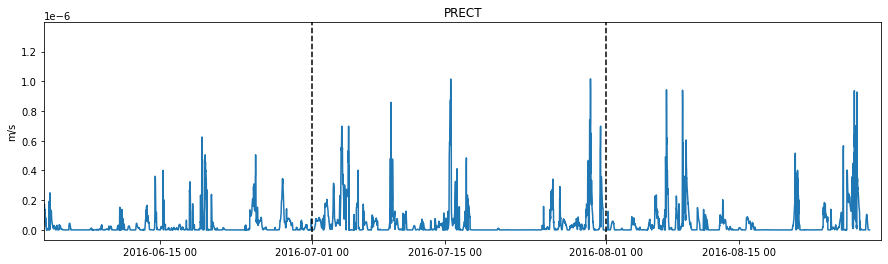

In [137]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(HMGcamDS_local.time.values, np.squeeze(HMGcamDS_local.PRECT.values))
axs.set_title('PRECT')
axs.set_ylabel('m/s')

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2016
endYear    = 2016

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

# axs.axhline(1, color = 'grey', linestyle = ':')

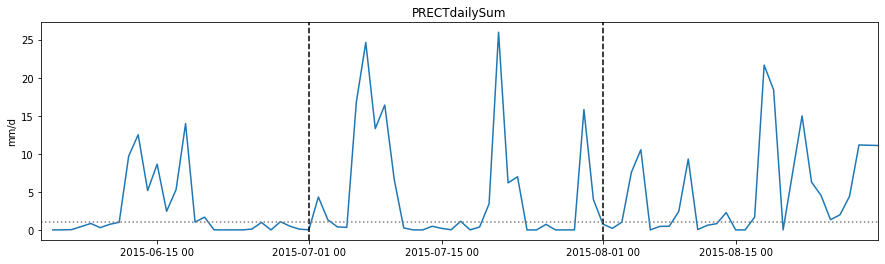

In [134]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(timeArr, np.squeeze(HMGcamDS_localDailyMean.PRECTdailySum.values))
axs.set_title('PRECTdailySum')
axs.set_ylabel('mm/d')

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')

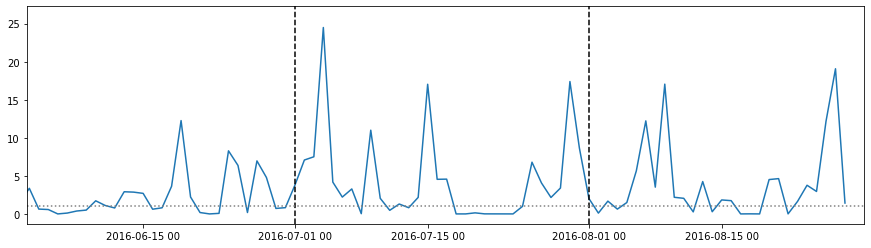

In [132]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(timeArr, np.squeeze(HMGcamDS_localDailyMean.PRECTdailySum.values))

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2016
endYear    = 2016

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')


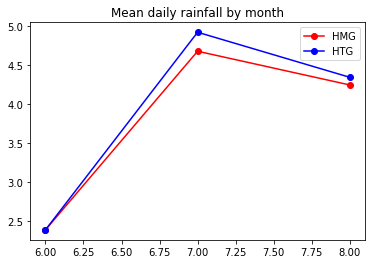

In [133]:
# June mean rain: 
iJune = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==6)[0]
iJuly = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==7)[0]
iAug  = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==8)[0]

HMGrain_june = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])
HTGrain_june = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])

HMGrain_july = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])
HTGrain_july = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])

HMGrain_aug  = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])
HTGrain_aug  = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])

plt.plot([6,7,8], [HMGrain_june, HMGrain_july, HMGrain_aug],'ro-')
plt.plot([6,7,8], [HTGrain_june, HTGrain_july, HTGrain_aug],'bo-')
plt.title('Mean daily rainfall by month')
plt.legend(['HMG','HTG'])